In [3]:
library(tidyverse)

-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6     v purrr   0.3.4
v tibble  3.1.7     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



## Loading and preprocessing the data

Here I'm using the "readr" package to read the data which handles most of the required steps to clean the data.

In [4]:
data_file <- "../input/activity.zip"
if (!file.exists(data_file)) {
  download.file("https://d396qusza40orc.cloudfront.net/repdata%2Fdata%2Factivity.zip", destfile = data_file)
}

Now let'a take a look at the data:

In [5]:
df <- read_csv(data_file)
dim(df)
head(df)
summary(df)

Rows: 17568 Columns: 3
-- Column specification --------------------------------------------------------
Delimiter: ","
dbl  (2): steps, interval
date (1): date

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 17568     3

steps,date,interval
<dbl>,<date>,<dbl>
NA,2012-10-01,0
NA,2012-10-01,5
NA,2012-10-01,10
NA,2012-10-01,15
NA,2012-10-01,20
NA,2012-10-01,25


     steps             date               interval     
 Min.   :  0.00   Min.   :2012-10-01   Min.   :   0.0  
 1st Qu.:  0.00   1st Qu.:2012-10-16   1st Qu.: 588.8  
 Median :  0.00   Median :2012-10-31   Median :1177.5  
 Mean   : 37.38   Mean   :2012-10-31   Mean   :1177.5  
 3rd Qu.: 12.00   3rd Qu.:2012-11-15   3rd Qu.:1766.2  
 Max.   :806.00   Max.   :2012-11-30   Max.   :2355.0  
 NA's   :2304                                          

We can see there are two months of data, with some NA values in it. For now we'll leave them be.


## What is mean total number of steps taken per day?

Now we draw a plot of total number of steps taken each.

Warning message:
"Removed 8 rows containing non-finite values (stat_bin)."


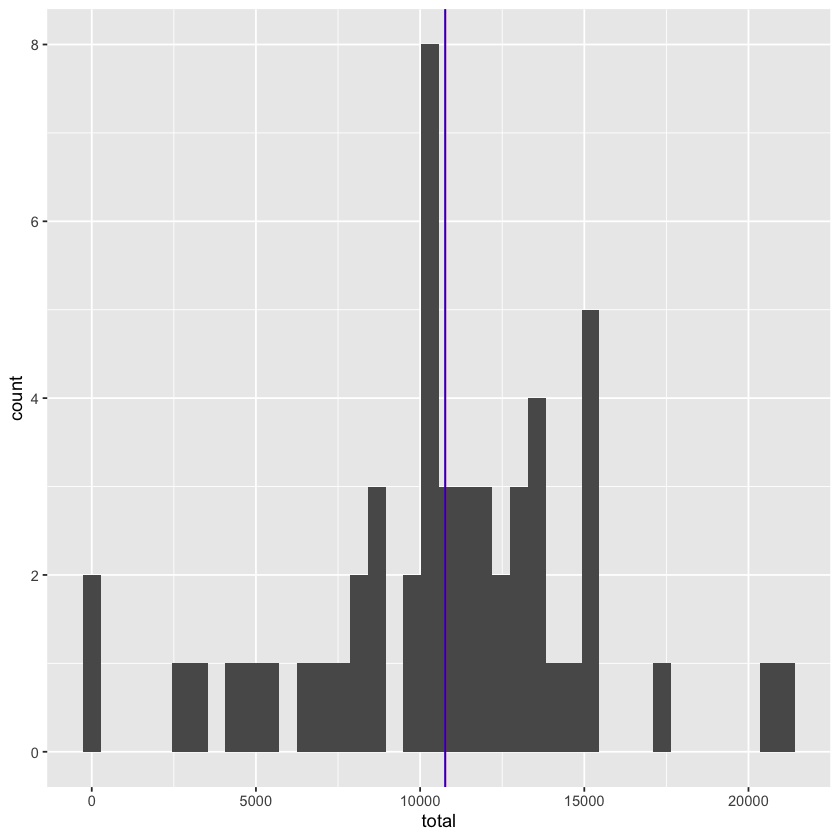

In [6]:
dfDaily <- df %>%
  group_by(date) %>%
  summarise(total = sum(steps))

meanSteps <- mean(dfDaily$total, na.rm = TRUE)
medianSteps <- median(dfDaily$total, na.rm = TRUE)

ggplot(dfDaily) +
  geom_histogram(aes(x = total), bins = 40) +
  geom_vline(xintercept = meanSteps, color = "red") +
  geom_vline(xintercept = medianSteps, color = "blue")

We can see some missing lines in the graph.

Calculated mean is: `r as.integer(meanSteps)` and the meidan is: `r as.integer(medianSteps)`.

And we can see that the mean and median are very close.

## What is the average daily activity pattern?

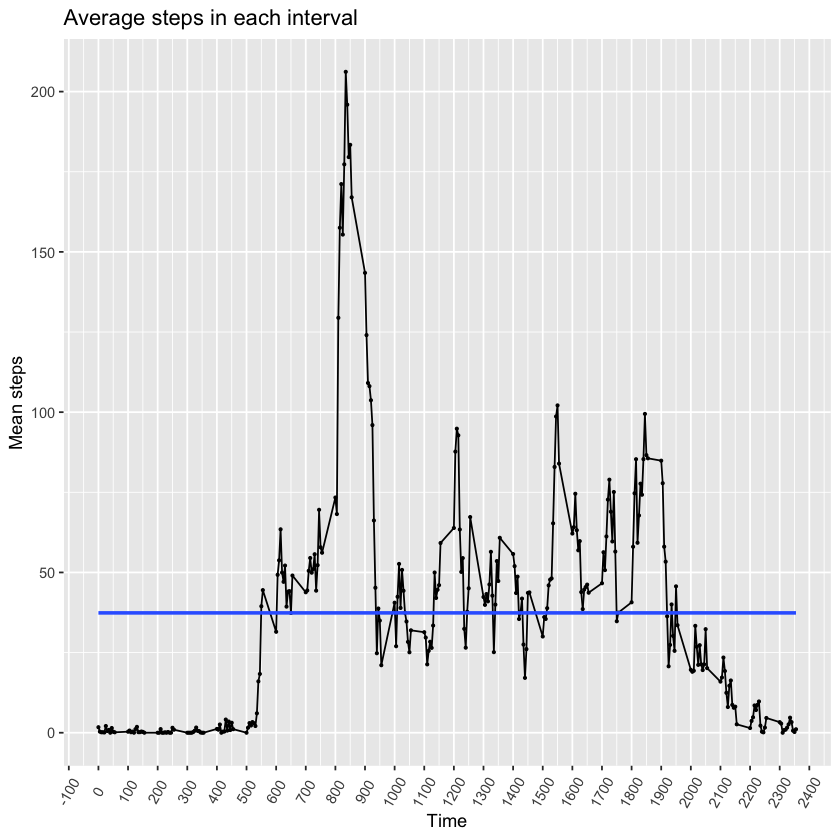

In [7]:
df %>%
  group_by(interval) %>%
  summarise(mean = mean(steps, na.rm = T)) %>%
  ggplot(aes(x = interval, y = mean)) +
  geom_line() +
  geom_point(size = 0.5) +
  scale_x_continuous(n.breaks = 23) +
  theme(axis.text.x = element_text(angle = 60, vjust = 0.5)) +
  stat_smooth(method = "lm", formula = y ~ 1, se = FALSE) +
  labs(x = "Time", y = "Mean steps", title = "Average steps in each interval")

And for finding the time interval where the most activity is in average:

In [8]:
averages <- df %>%
  group_by(interval) %>%
  summarise(mean = mean(steps, na.rm = T))

max <- averages[which.max(averages$mean), ]
max

interval,mean
<dbl>,<dbl>
835,206.1698


And the code gices us the answer is: `r max$interval`.

## Imputing missing values

There are a total of `r sum(is.na(df$steps))` missing values in the data whcih is 
**`r as.integer(mean(is.na(df$steps))*100)`%** 
of the data.

For imputing the NA's I'll simply use the mean of that time interval.

In [9]:
df2 <- df %>%
  group_by(interval) %>%
  mutate(steps = ifelse(is.na(steps), mean(steps, na.rm = T), steps))

Now we have df2 with no NA's.

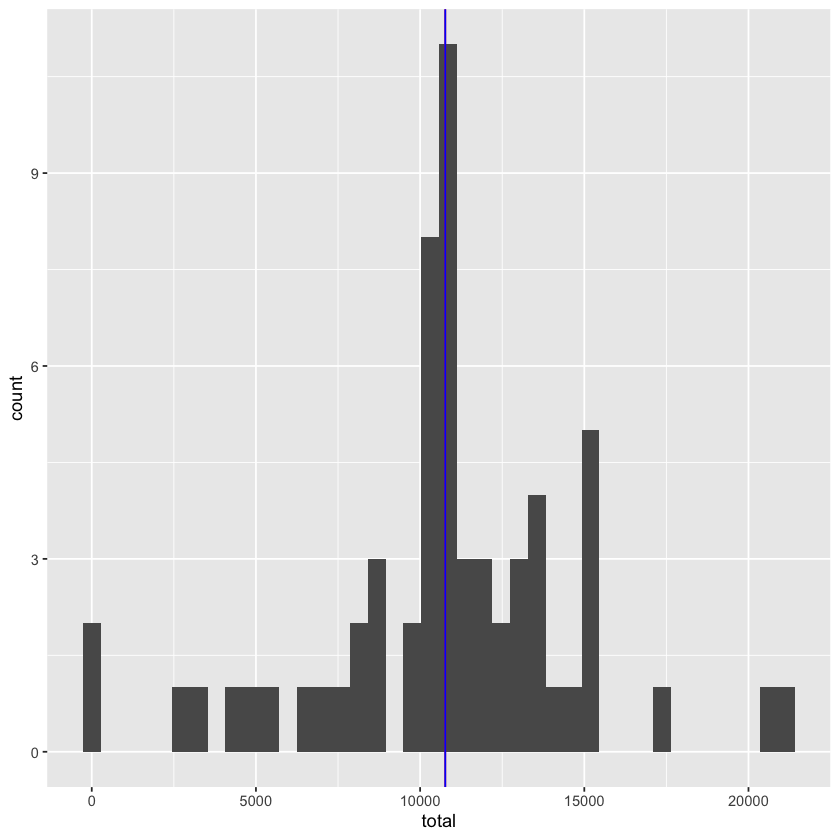

In [10]:
dfDaily <- df2 %>%
  group_by(date) %>%
  summarise(total = sum(steps))

meanSteps <- mean(dfDaily$total, na.rm = TRUE)
medianSteps <- median(dfDaily$total, na.rm = TRUE)

ggplot(dfDaily) +
  geom_histogram(aes(x = total), bins = 40) +
  geom_vline(xintercept = meanSteps, color = "red") +
  geom_vline(xintercept = medianSteps, color = "blue")

Since we have replaced the NA's with the mean, we can see that the plot does not change so much. In fact, just some bars have a bit higher count and thats all.

## Are there differences in activity patterns between weekdays and weekends?

With this code we will add a column indicating weekday and weekends.

In [11]:
df <- df %>%
  mutate(weekday = ifelse(strftime(date, "%a") == "Sat" | strftime(date, "%a") == "Sun", "weekend", "weekday")) %>%
  mutate(across(weekday, as.factor))

summary(df$weekday)

weekday weekend 
  12960    4608

Now let's plot average step taken in each time interval for the two categories:

`summarise()` has grouped output by 'interval'. You can override using the
`.groups` argument.


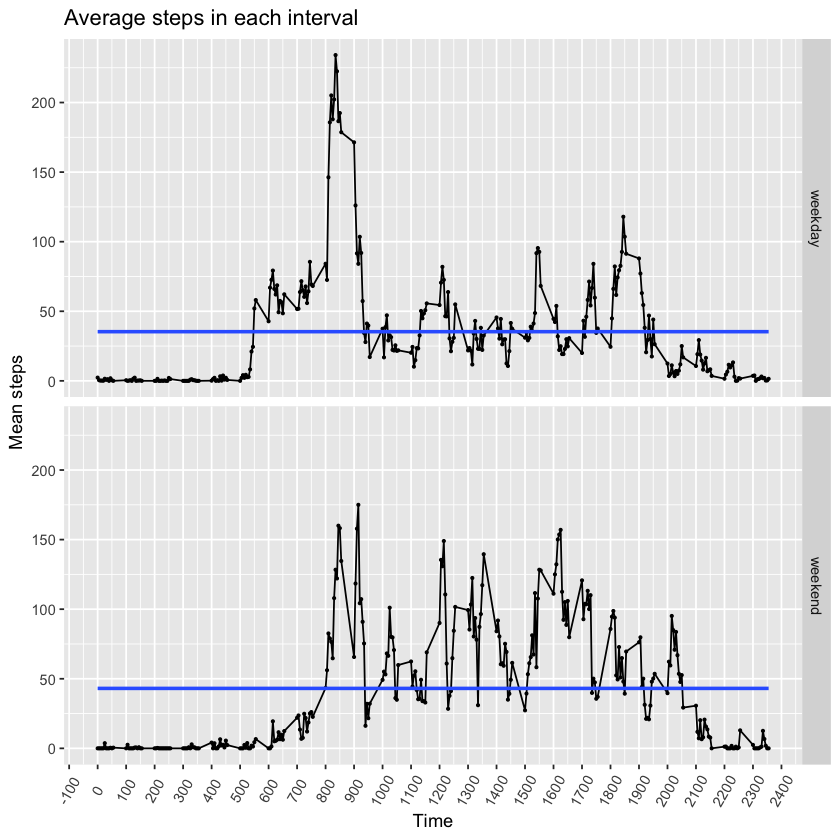

In [12]:
df %>%
  group_by(interval, weekday) %>%
  summarise(mean = mean(steps, na.rm = T)) %>%
  ggplot(aes(x = interval, y = mean)) +
  geom_line() +
  geom_point(size = 0.5) +
  facet_grid(rows = vars(weekday)) +
  scale_x_continuous(n.breaks = 23) +
  theme(axis.text.x = element_text(angle = 60, vjust = 0.5)) +
  stat_smooth(method = "lm", formula = y ~ 1, se = FALSE) +
  labs(x = "Time", y = "Mean steps", title = "Average steps in each interval")